## Import libraries and setup

In [59]:
import pandas as pd
import numpy as np
import re


## Load data and Preview first row 

In [60]:

df = pd.read_csv("immovlan_final_file.csv")
df.head()

,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Type of heating,Type of glazing,Elevator,Number of facades,Garden,Surface garden,Terrace,Surface terrace,Total land surface,Swimming pool
0,https://immovlan.be/en/detail/studio/for-sale/...,vbd20021,175 000 €,New,On contract,0.0,51 m²,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,NaN
1,https://immovlan.be/en/detail/apartment/for-sa...,vbd30235,415 000 €,New,On contract,1.0,70 m²,No,NaN,Yes,...,NaN,NaN,Yes,2.0,Yes,NaN,Yes,20 m²,NaN,Yes
2,https://immovlan.be/en/detail/residence/for-sa...,vbd46297,399 000 €,NaN,NaN,2.0,129 m²,NaN,NaN,Yes,...,Gas,Double glass,NaN,4.0,Yes,NaN,NaN,NaN,NaN,NaN
3,https://immovlan.be/en/detail/apartment/for-sa...,vbd36813,229 000 €,New,NaN,2.0,82 m²,NaN,NaN,NaN,...,NaN,NaN,Yes,3.0,No,NaN,Yes,8 m²,NaN,NaN
4,https://immovlan.be/en/detail/apartment/for-sa...,vbb60643,320 000 €,New,NaN,3.0,106 m²,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Yes,NaN,Yes,6 m²,NaN,NaN


## Check duplicates rows and unique value IDs 

In [61]:
# check 1: Duplicate rows 
duplicate_rows = df.duplicated().sum()
print(f"\n1. Exact duplicate rows: {duplicate_rows}")

# check 2: Duplicate property IDs
if 'Property ID' in df.columns:
    duplicate_ids = df['Property ID'].duplicated().sum()
    print(f"2. Duplicate Property IDs: {duplicate_ids}")

duplicate_remove = df.drop_duplicates()
print(duplicate_remove.shape)


1. Exact duplicate rows: 0
2. Duplicate Property IDs: 0
(16309, 26)


## Check for whitespace - 

lambda x: isinstance(x, str) and x != x.strip()
For each cell x in the DataFrame:
isinstance(x, str) → checks if the cell contains a string.
x.strip() → removes leading/trailing whitespace.
x != x.strip() → will be True if trimming changes the value (i.e., whitespace existed).

In [62]:
has_whitespace = df.map(lambda x: isinstance(x, str) and x != x.strip()).any().any()
print("Contains whitespace?", has_whitespace)

Contains whitespace? False


## Check Data Types

In [63]:
# df.dtypes

df.info(show_counts=True, memory_usage=True, verbose=True)
df_obj = df.select_dtypes(include=['object'])
print(df_obj.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16309 entries, 0 to 16308
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    16309 non-null  object 
 1   Property ID            16309 non-null  object 
 2   Price                  15725 non-null  object 
 3   State of the property  11846 non-null  object 
 4   Availability           7001 non-null   object 
 5   Number of bedrooms     14083 non-null  float64
 6   Livable surface        13294 non-null  object 
 7   Furnished              8383 non-null   object 
 8   Attic                  3661 non-null   object 
 9   Garage                 7044 non-null   object 
 10  Number of garages      3799 non-null   float64
 11  Kitchen equipment      4380 non-null   object 
 12  Kitchen type           2181 non-null   object 
 13  Number of bathrooms    12042 non-null  float64
 14  Number of showers      3538 non-null   float64
 15  Nu

## Fixing columns which are numbers but shown as object 

Price                   object  ❌ Has "€" symbol
Livable surface         object  ❌ Has "m²" unit
Surface garden          object  ❌ Has "m²" unit

In [64]:
# ============================================
# STEP 1: Define cleaning function
# ============================================

def clean_numeric(value):
    """Universal numeric cleaner"""
    if pd.isna(value):
        return np.nan
    
    value = str(value)
    value = re.sub(r'[€$£,\s]', '', value)   # Remove currency, commas, spaces
    value = re.sub(r'm²?', '', value)         # Remove m² or m
    value = re.sub(r'[a-zA-Z]', '', value)    # Remove letters
    
    try:
        return float(value)
    except:
        return np.nan

# ============================================
# STEP 2: Apply to columns
# ============================================

columns = ['Price', 'Livable surface', 'Surface garden','Surface terrace', 'Total land surface']

for col in columns:
    if col in df.columns:
        # Before
        before_type = df[col].dtype
        before_sample = df[col].dropna().iloc[0] if not df[col].dropna().empty else None
        
        # Clean
        df[col] = df[col].apply(clean_numeric)
        
        # After
        after_type = df[col].dtype
        after_sample = df[col].dropna().iloc[0] if not df[col].dropna().empty else None
        
    # Report
        print(f"\n✓ {col}:")
        print(f"    {before_type} → {after_type}")
        print(f"    '{before_sample}' → {after_sample}")     


✓ Price:
    object → float64
    '175 000 €' → 175000.0

✓ Livable surface:
    object → float64
    '51 m²' → 51.0

✓ Surface garden:
    object → float64
    '315 m²' → 315.0

✓ Surface terrace:
    object → float64
    '20 m²' → 20.0

✓ Total land surface:
    object → float64
    '320 m²' → 320.0


## Convert yes and no values to 1, 0

In [65]:
yes_or_no_columns = ["Furnished", "Attic", "Garage", "Elevator", "Garden", "Terrace", "Swimming pool"]

for column in yes_or_no_columns:
    if column in df.columns:
        df[column] = (      
            df[column]
            .astype(str)                     # make sure everything is text
            .str.strip()                     # remove spaces
            .str.lower()                     # make all text lowercase
            .map({
                "yes": 1, "y": 1, "true": 1, "1": 1,
                "no": 0, "n": 0, "false": 0, "0": 0
            })
        )
display(df[yes_or_no_columns].head(20))

,Furnished,Attic,Garage,Elevator,Garden,Terrace,Swimming pool
0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,0.0,NaN,1.0,1.0,1.0,1.0,1.0
2,NaN,NaN,1.0,NaN,1.0,NaN,NaN
3,NaN,NaN,NaN,1.0,0.0,1.0,NaN
4,NaN,NaN,NaN,NaN,1.0,1.0,NaN
5,0.0,NaN,NaN,1.0,0.0,1.0,NaN
6,0.0,1.0,1.0,0.0,1.0,1.0,NaN
7,0.0,NaN,NaN,NaN,1.0,1.0,NaN
8,NaN,NaN,NaN,1.0,0.0,1.0,NaN
9,0.0,1.0,1.0,0.0,1.0,1.0,0.0


## Checking for missing values

In [66]:

missing_count = df.isnull().sum()
display(missing_count)

url                          0
Property ID                  0
Price                      584
State of the property     4463
Availability              9308
Number of bedrooms        2226
Livable surface           3015
Furnished                 7926
Attic                    12648
Garage                    9265
Number of garages        12510
Kitchen equipment        11929
Kitchen type             14128
Number of bathrooms       4267
Number of showers        12771
Number of toilets         6295
Type of heating           6966
Type of glazing           9232
Elevator                  5486
Number of facades         6492
Garden                    3523
Surface garden           13578
Terrace                   2721
Surface terrace           8861
Total land surface        9319
Swimming pool            12389
dtype: int64

## Replace missing values by Nan

In [67]:
# Replace empty strings with pd.NA
df = df.replace("", pd.NA)

# Convert all columns to object type to allow string "nan"
df = df.astype(object)

# Fill missing values with string "nan"
df = df.fillna("nan")

display(df)

,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Type of heating,Type of glazing,Elevator,Number of facades,Garden,Surface garden,Terrace,Surface terrace,Total land surface,Swimming pool
0,https://immovlan.be/en/detail/studio/for-sale/...,vbd20021,175000.0,New,On contract,0.0,51.0,nan,nan,nan,...,nan,nan,nan,nan,0.0,nan,0.0,nan,nan,nan
1,https://immovlan.be/en/detail/apartment/for-sa...,vbd30235,415000.0,New,On contract,1.0,70.0,0.0,nan,1.0,...,nan,nan,1.0,2.0,1.0,nan,1.0,20.0,nan,1.0
2,https://immovlan.be/en/detail/residence/for-sa...,vbd46297,399000.0,nan,nan,2.0,129.0,nan,nan,1.0,...,Gas,Double glass,nan,4.0,1.0,nan,nan,nan,nan,nan
3,https://immovlan.be/en/detail/apartment/for-sa...,vbd36813,229000.0,New,nan,2.0,82.0,nan,nan,nan,...,nan,nan,1.0,3.0,0.0,nan,1.0,8.0,nan,nan
4,https://immovlan.be/en/detail/apartment/for-sa...,vbb60643,320000.0,New,nan,3.0,106.0,nan,nan,nan,...,nan,nan,nan,nan,1.0,nan,1.0,6.0,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16304,https://immovlan.be/en/detail/villa/for-sale/1...,vwd15514,995000.0,Excellent,On contract,6.0,300.0,nan,nan,1.0,...,Not specified,nan,nan,4.0,1.0,750.0,1.0,20.0,1448.0,1.0
16305,https://immovlan.be/en/detail/investment-prope...,rbu64401,645000.0,nan,nan,4.0,nan,nan,nan,1.0,...,nan,nan,nan,nan,nan,nan,1.0,nan,213.0,nan
16306,https://immovlan.be/en/detail/investment-prope...,rbt71588,649000.0,Normal,nan,5.0,nan,nan,nan,nan,...,Gas,nan,0.0,2.0,nan,nan,nan,nan,110.0,nan
16307,https://immovlan.be/en/detail/apartment/for-sa...,rbu61550,239000.0,nan,On contract,2.0,100.0,0.0,nan,1.0,...,Electricity,nan,1.0,nan,0.0,nan,0.0,nan,nan,nan


Extract information from URLs 

In [68]:
# Extract the parts
df[['type', 'postal_code', 'city']] = df['url'].str.extract(
    r'detail/([^/]+)/for-sale/(\d+)/([^/]+)/'
)

print(df[['type', 'postal_code', 'city']])


                      type postal_code               city
0                   studio        4000              liege
1                apartment        1410           waterloo
2                residence        1501          buizingen
3                apartment        7000               mons
4                apartment        7000               mons
...                    ...         ...                ...
16304                villa        1440  braine-le-chateau
16305  investment-property        2530           boechout
16306  investment-property        8600          diksmuide
16307            apartment        2630         aartselaar
16308            apartment        8630             veurne

[16309 rows x 3 columns]


## Save cleaned data into new file 

In [69]:
df.to_csv("immovlan_cleaned_file.csv", index=False, encoding="utf-8")
df.head(1)



,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Number of facades,Garden,Surface garden,Terrace,Surface terrace,Total land surface,Swimming pool,type,postal_code,city
0,https://immovlan.be/en/detail/studio/for-sale/...,vbd20021,175000.0,New,On contract,0.0,51.0,nan,nan,nan,...,nan,0.0,nan,0.0,nan,nan,nan,studio,4000,liege


## Create dataframe on type using two categories - Businesses and Land 

In [83]:
df = pd.read_csv("immovlan_cleaned_file.csv")
# Clean up the 'type' column
df['type'] = df['type'].str.lower().str.replace('-', ' ').str.strip()         # removes spaces and capitalizes words
df["type"].unique()                      # display list from column 

# Define subcategories
business_types = ['commercial building', 'industrial building', 'office space', 'business surface']
land_types = ['land', 'development site', 'to parcel out site']

# Filter rows where 'type' matches any of the business or land subcategories
property_df = df[df['type'].isin(business_types + land_types)]

# Preview
display(property_df['type'].value_counts())
display(property_df.head())



type
land                   642
commercial building    439
development site       394
industrial building    172
office space           123
business surface        45
to parcel out site      17
Name: count, dtype: int64

,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Surface terrace,Total land surface,Swimming pool,type,postal_code,city,Region,province,price_per_sqm,Price_per_sqm_land
21,https://immovlan.be/en/detail/commercial-build...,rbu66908,150000.0,NaN,On contract,NaN,NaN,NaN,NaN,NaN,...,34.0,NaN,NaN,commercial building,1800,vilvoorde,Flanders,Flemish Brabant,NaN,NaN
24,https://immovlan.be/en/detail/land/for-sale/69...,vbd36859,75000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,694.0,NaN,land,6950,nassogne,Wallonia,Luxembourg,NaN,108.069164
33,https://immovlan.be/en/detail/land/for-sale/96...,rbu60077,180000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1514.0,NaN,land,9600,ronse,Flanders,East Flanders,NaN,118.890357
35,https://immovlan.be/en/detail/commercial-build...,rbu50976,499000.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,345.0,NaN,commercial building,1570,galmaarden,Flanders,Flemish Brabant,NaN,1446.376812
37,https://immovlan.be/en/detail/land/for-sale/62...,vbd49230,65000.0,NaN,On contract,NaN,NaN,NaN,NaN,NaN,...,NaN,460.0,NaN,land,6230,pont-a-celles,Wallonia,Hainaut,NaN,141.304348


## Function for catergories

In [84]:

def load_and_filter_properties(
    csv_path: str,
    business_types=None,
    land_types=None,
    show_preview=True
):
    """
    Loads a CSV file, cleans the 'type' column, 
    filters for specific property categories, 
    and optionally displays a preview.
    
    Parameters
    ----------
    csv_path : str
        Path to the CSV file.
    business_types : list, optional
        List of business-related property types to include.
    land_types : list, optional
        List of land-related property types to include.
    show_preview : bool, default=True
        Whether to display value counts and sample rows.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame containing only the selected property types.
    """
    # Default categories
    if business_types is None:
        business_types = ['commercial building', 'industrial building', 'office space', 'business surface']
    if land_types is None:
        land_types = ['land', 'development site', 'to parcel out site']

    # Load data
    df = pd.read_csv(csv_path)

    # Clean up the 'type' column
    df['type'] = (
        df['type']
        .str.lower()
        .str.replace('-', ' ')
        .str.strip()
    )

    # Filter relevant property types
    property_df = df[df['type'].isin(business_types + land_types)]

    # Optional preview
    if show_preview:
        display(property_df['type'].value_counts())
        display(property_df.head(50))

    return property_df

filtered_df = load_and_filter_properties("immovlan_cleaned_file.csv")


type
land                   642
commercial building    439
development site       394
industrial building    172
office space           123
business surface        45
to parcel out site      17
Name: count, dtype: int64

,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Surface terrace,Total land surface,Swimming pool,type,postal_code,city,Region,province,price_per_sqm,Price_per_sqm_land
21,https://immovlan.be/en/detail/commercial-build...,rbu66908,150000.0,NaN,On contract,NaN,NaN,NaN,NaN,NaN,...,34.0,NaN,NaN,commercial building,1800,vilvoorde,Flanders,Flemish Brabant,NaN,NaN
24,https://immovlan.be/en/detail/land/for-sale/69...,vbd36859,75000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,694.0,NaN,land,6950,nassogne,Wallonia,Luxembourg,NaN,108.069164
33,https://immovlan.be/en/detail/land/for-sale/96...,rbu60077,180000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1514.0,NaN,land,9600,ronse,Flanders,East Flanders,NaN,118.890357
35,https://immovlan.be/en/detail/commercial-build...,rbu50976,499000.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,345.0,NaN,commercial building,1570,galmaarden,Flanders,Flemish Brabant,NaN,1446.376812
37,https://immovlan.be/en/detail/land/for-sale/62...,vbd49230,65000.0,NaN,On contract,NaN,NaN,NaN,NaN,NaN,...,NaN,460.0,NaN,land,6230,pont-a-celles,Wallonia,Hainaut,NaN,141.304348
47,https://immovlan.be/en/detail/industrial-build...,rbu66785,665528.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,411.0,NaN,industrial building,8000,brugge,Flanders,West Flanders,NaN,1619.289538
49,https://immovlan.be/en/detail/commercial-build...,vbd47313,110000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,commercial building,1000,brussels,Brussels,Brussels,NaN,NaN
79,https://immovlan.be/en/detail/land/for-sale/14...,vbd44103,255000.0,NaN,On contract,NaN,NaN,NaN,NaN,NaN,...,NaN,1750.0,NaN,land,1490,court-saint-etienne,Wallonia,Walloon Brabant,NaN,145.714286
92,https://immovlan.be/en/detail/development-site...,rbu49574,440000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,707.0,NaN,development site,3920,lommel,Flanders,Limburg,NaN,622.347949
104,https://immovlan.be/en/detail/office-space/for...,vbd47443,279000.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,340.0,NaN,office space,4020,wandre,Wallonia,Liege,NaN,820.588235


## Regions 
A. Deterministic postcode -> region mapping 

In [72]:
def postcode_to_region(pc):
    if pd.isna(pc):
        return "Unknown"
    pc = int(pc)

    # Brussels
    if 1000 <= pc <= 1299:
        return "Brussels"

    # Wallonia
    if 1300 <= pc <= 1499:
        return "Wallonia"
    if 4000 <= pc <= 7999:
        return "Wallonia"

    # Flanders
    if 1500 <= pc <= 3999:
        return "Flanders"
    if 8000 <= pc <= 9999:
        return "Flanders"

    return "Unknown"

df["Region"] = df["postal_code"].apply(postcode_to_region)

# Test 
print("Region distribution:")
print(df["Region"].value_counts(dropna=False))

df.to_csv("immovlan_cleaned_file.csv", index=False, encoding="utf-8")

Region distribution:
Region
Wallonia    8142
Flanders    6724
Brussels    1443
Name: count, dtype: int64


B. Map postcode to province

In [73]:
provinces = {
    "brussels": list(range(1000, 1300)),
    "brabant_walloon": list(range(1300, 1500)),
    "brabant_flemish": list(range(1500, 2000)) + list(range(3000, 3500)),
    "antwerp": list(range(2000, 3000)),
    "limburg": list(range(3500, 4000)),
    "liege": list(range(4000, 4500)),
    "namur": list(range(4500, 5681)),
    "hainaut": list(range(5681, 6600)) + list(range(7000, 8000)),
    "luxembourg": list(range(6600, 7000)),
    "west_flanders": list(range(8000, 9000)),
    "east_flanders": list(range(9000, 10000))
}
def postcode_to_province(postcode):
    # Brussels
    if postcode in provinces["brussels"]:
        return "Brussels"
    # Walloon Brabant
    if postcode in provinces["brabant_walloon"]:
        return "Walloon Brabant"
    # Flemish Brabant
    if postcode in provinces["brabant_flemish"]:
        return "Flemish Brabant"
    # Antwerp
    if postcode in provinces["antwerp"]:
        return "Antwerp"
    # Limburg
    if postcode in provinces["limburg"]:
        return "Limburg"

    # Liege
    if postcode in provinces["liege"]:
        return "Liege"

    # Namur
    if postcode in provinces["namur"]:
        return "Namur"

    # Hainaut
    if postcode in provinces["hainaut"]:
        return "Hainaut"

    # Luxembourg
    if postcode in provinces["luxembourg"]:
        return "Luxembourg"

    # West Flanders
    if postcode in provinces["west_flanders"]:
        return "West Flanders"

    # East Flanders
    if postcode in provinces["east_flanders"]:
        return "East Flanders"

    return "Unknown"

df["province"] = df["postal_code"].apply(postcode_to_province)

# Test
print("Provinces distribution:")
print(df["province"].value_counts(dropna=False))

df.to_csv("immovlan_cleaned_file.csv", index=False, encoding="utf-8")

Provinces distribution:
province
Namur              2447
Walloon Brabant    1625
Hainaut            1503
Limburg            1502
Brussels           1443
Antwerp            1408
Luxembourg         1387
West Flanders      1293
Flemish Brabant    1283
East Flanders      1238
Liege              1180
Name: count, dtype: int64


## calculate area per meter square

In [74]:
df["price_per_sqm"] = df["Price"] / df["Livable surface"]
df['Price_per_sqm_land'] = df['Price'] / df['Total land surface']

df.to_csv("immovlan_cleaned_file.csv", index=False, encoding="utf-8")

## Visualization  

In [75]:
import plotly.express as px

print("="*70)
print("📊 BOX PLOT: Price Distribution by Province")
print("="*70)

# Remove missing prices and provinces
df_plot = df[df['Price'].notna() & df['province'].notna()].copy()

# Create interactive box plot
fig = px.box(
    df_plot, 
    x='province', 
    y='Price',
    title='Property Prices by Province',
    labels={'Price': 'Price (€)', 'province': 'Province', 'type': 'Property type'},
    color='province',  # Different color for each province
    hover_data=['Price','type']  # Show price on hover
)

# Customize layout
fig.update_layout(
    height=600,
    xaxis_tickangle=-45,  # Rotate labels
    showlegend=True,
    font=dict(size=12)
)

# Format y-axis as currency
fig.update_yaxes(tickformat='€,.0f')

fig.show()

print(f"\n✓ Displaying {len(df_plot)} properties across {df_plot['province'].nunique()} provinces")


📊 BOX PLOT: Price Distribution by Province



✓ Displaying 15725 properties across 11 provinces


In [76]:
import plotly.graph_objects as go 


print("="*70)
print("📊 BAR CHART: Average Price by Province")
print("="*70)

# Calculate average price per province
avg_prices = df.groupby('province')['Price'].agg(['mean', 'median', 'count']).reset_index()
avg_prices = avg_prices.sort_values('mean', ascending=False)

print("\nAverage Prices by Province:")
print(avg_prices)

# Create bar chart
fig = go.Figure()

# Add bars for mean price
fig.add_trace(go.Bar(
    x=avg_prices['province'],
    y=avg_prices['mean'],
    name='Average Price',
    text=avg_prices['mean'].apply(lambda x: f'€{x:,.0f}'),
    textposition='outside',
    marker_color='lightblue',
    hovertemplate='<b>%{x}</b><br>Average: €%{y:,.0f}<extra></extra>'
))

# Add bars for median price
fig.add_trace(go.Bar(
    x=avg_prices['province'],
    y=avg_prices['median'],
    name='Median Price',
    text=avg_prices['median'].apply(lambda x: f'€{x:,.0f}'),
    textposition='outside',
    marker_color='lightcoral',
    hovertemplate='<b>%{x}</b><br>Median: €%{y:,.0f}<extra></extra>'
))

fig.update_layout(
    title='Average vs Median Price by Province',
    xaxis_title='Province',
    yaxis_title='Price (€)',
    barmode='group',  # Side-by-side bars
    height=600,
    xaxis_tickangle=-45,
    hovermode='x unified'
)

fig.update_yaxes(tickformat='€,.0f')

fig.show()

print(f"\n✓ Chart created for {len(avg_prices)} provinces")

📊 BAR CHART: Average Price by Province

Average Prices by Province:
           province           mean    median  count
1          Brussels  548583.616725  429000.0   1435
3   Flemish Brabant  496121.361582  414904.0   1239
2     East Flanders  448566.978723  385000.0   1222
9   Walloon Brabant  442028.372281  385000.0   1609
0           Antwerp  385367.681492  335000.0   1394
10    West Flanders  364727.584712  319500.0   1269
6           Limburg  348713.569952  325000.0   1451
8             Namur  301085.254366  279500.0   2233
7        Luxembourg  301006.332064  275000.0   1313
5             Liege  289565.280215  275000.0   1117
4           Hainaut  259911.762994  232400.0   1443



✓ Chart created for 11 provinces


In [77]:
from plotly.subplots import make_subplots

print("="*70)
print("📊 DASHBOARD: Comprehensive Province Analysis")
print("="*70)

df_plot = df[df['Price'].notna() & df['province'].notna()].copy()

# Calculate statistics
stats = df_plot.groupby('province').agg({
    'Price': ['mean', 'median', 'count', 'min', 'max']
}).round(0)

stats.columns = ['Mean', 'Median', 'Count', 'Min', 'Max']
stats = stats.reset_index().sort_values('Mean', ascending=False)

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Average Price by Province',
        'Property Count by Province',
        'Price Range (Min-Max)',
        'Mean vs Median Price'
    ),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'scatter'}, {'type': 'scatter'}]]
)

# 1. Average Price
fig.add_trace(
    go.Bar(x=stats['province'], y=stats['Mean'], name='Avg Price', marker_color='lightblue'),
    row=1, col=1
)

# 2. Property Count
fig.add_trace(
    go.Bar(x=stats['province'], y=stats['Count'], name='Count', marker_color='lightgreen'),
    row=1, col=2
)

# 3. Price Range
fig.add_trace(
    go.Scatter(x=stats['province'], y=stats['Min'], mode='markers', 
               name='Min', marker=dict(size=10, color='red')),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=stats['province'], y=stats['Max'], mode='markers', 
               name='Max', marker=dict(size=10, color='green')),
    row=2, col=1
)

# 4. Mean vs Median
fig.add_trace(
    go.Scatter(x=stats['province'], y=stats['Mean'], mode='lines+markers',
               name='Mean', line=dict(color='blue')),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=stats['province'], y=stats['Median'], mode='lines+markers',
               name='Median', line=dict(color='red')),
    row=2, col=2
)

# Update layout
fig.update_layout(
    height=900,
    showlegend=True,
    title_text="Province Price Analysis Dashboard"
)

# Rotate x-axis labels
fig.update_xaxes(tickangle=-45)

fig.show()

print(f"\n✓ Dashboard created with {len(stats)} provinces")

📊 DASHBOARD: Comprehensive Province Analysis



✓ Dashboard created with 11 provinces


In [94]:
# Outliers Describe price by type
fig = px.box(property_df, x='type', y='Price',
             title='Price Distribution by Property Type')
fig.show()


# Show top 10 highest prices in each type
property_df[property_df['type'].isin(['industrial building','office space'])] \
    .sort_values('Price', ascending=False).head(10)



,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Surface terrace,Total land surface,Swimming pool,type,postal_code,city,Region,province,price_per_sqm,Price_per_sqm_land
12669,https://immovlan.be/en/detail/office-space/for...,rbu62303,13827600.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3841.0,NaN,office space,9000,gent,Flanders,East Flanders,NaN,3600.000000
6737,https://immovlan.be/en/detail/office-space/for...,rbu62304,9280800.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2578.0,NaN,office space,9000,gent,Flanders,East Flanders,NaN,3600.000000
13351,https://immovlan.be/en/detail/office-space/for...,rbu64733,6800000.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2000.0,NaN,office space,9800,deinze,Flanders,East Flanders,NaN,3400.000000
6455,https://immovlan.be/en/detail/office-space/for...,rbu67151,6800000.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2000.0,NaN,office space,9810,nazareth,Flanders,East Flanders,NaN,3400.000000
15623,https://immovlan.be/en/detail/industrial-build...,vbd44961,6278860.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12556.0,NaN,industrial building,7522,blandain,Wallonia,Hainaut,NaN,500.068493
15462,https://immovlan.be/en/detail/industrial-build...,vbd38711,6000000.0,Normal,On contract,NaN,NaN,NaN,NaN,NaN,...,NaN,9900.0,NaN,industrial building,5030,gembloux,Wallonia,Namur,NaN,606.060606
10886,https://immovlan.be/en/detail/office-space/for...,vbd48470,5700000.0,To be renovated,Immediately,NaN,NaN,NaN,NaN,NaN,...,NaN,9510.0,NaN,office space,1050,elsene,Brussels,Brussels,NaN,599.369085
2088,https://immovlan.be/en/detail/office-space/for...,rbu64709,4389400.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1291.0,NaN,office space,9800,deinze,Flanders,East Flanders,NaN,3400.000000
13677,https://immovlan.be/en/detail/office-space/for...,rbu52248,3995000.0,Excellent,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2273.0,NaN,office space,1731,zellik,Flanders,Flemish Brabant,NaN,1757.589089
5289,https://immovlan.be/en/detail/office-space/for...,rbu64710,2927400.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,861.0,NaN,office space,9800,deinze,Flanders,East Flanders,NaN,3400.000000


In [104]:

# ============================================
# 2. DEFINE TYPES
# ============================================
business_types = ['commercial building', 'industrial building', 'office space', 'business surface']
land_types = ['land', 'development site', 'to parcel out site']

# ============================================
# 3. CREATE SEPARATE DATAFRAMES
# ============================================
business_df = property_df[
    property_df['type'].str.lower().isin([t.lower() for t in business_types])
].copy()

land_df = property_df[
    property_df['type'].str.lower().isin([t.lower() for t in land_types])
].copy()


# ============================================
# 4. FILTER COLUMNS
# ============================================
columns = ['Price', 'State of the property', 'Elevator', 'Total land surface',
           'type', 'city', 'province', 'Price_per_sqm_land']

existing_cols = [col for col in columns if col in property_df.columns]

business_df = business_df[existing_cols]
land_df = land_df[existing_cols]


# ============================================
# 5. SUMMARY
# ============================================
print("✅ DataFrames Created:")
print(f"  business_df:    {len(business_df):,} rows")
print(f"  land_df:        {len(land_df):,} rows")


# ============================================
# 6. READY TO USE!
# ============================================
# Now you can work with:
# - residential_df for houses/apartments
# - business_df for commercial properties
# - land_df for land/development sites
# ============================================

✅ DataFrames Created:
  business_df:    779 rows
  land_df:        1,053 rows


📊 BUSINESS PROPERTIES - DISTRIBUTION ANALYSIS

Dataset Size: 779 properties

Price Statistics:
  Mean:   €536,411
  Median: €329,000
  Std:    €885,578
  Min:    €1,667
  Max:    €13,827,600

Percentiles:
  25th: €205,742
  50th: €329,000
  75th: €546,100
  90th: €980,000
  95th: €1,495,377
  99th: €4,144,872


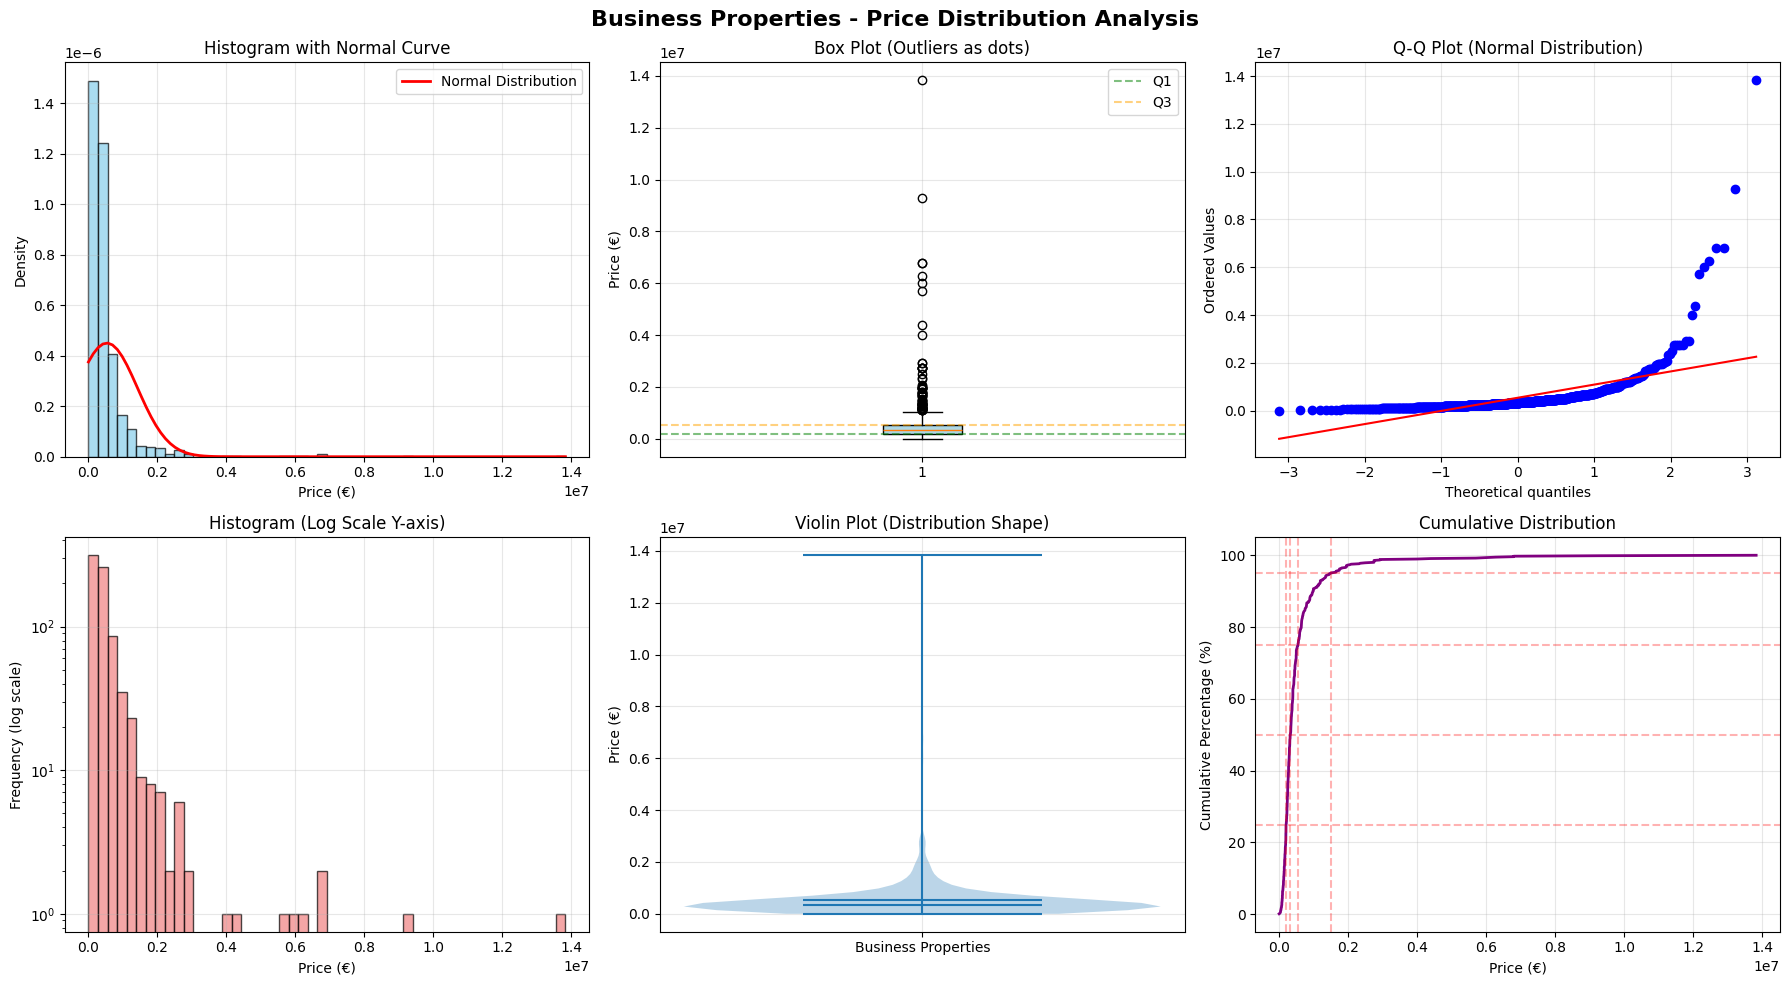


✅ Distribution graphs created!


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

print("="*70)
print("📊 BUSINESS PROPERTIES - DISTRIBUTION ANALYSIS")
print("="*70)

# Basic statistics
print(f"\nDataset Size: {len(business_df):,} properties")
print(f"\nPrice Statistics:")
print(f"  Mean:   €{business_df['Price'].mean():,.0f}")
print(f"  Median: €{business_df['Price'].median():,.0f}")
print(f"  Std:    €{business_df['Price'].std():,.0f}")
print(f"  Min:    €{business_df['Price'].min():,.0f}")
print(f"  Max:    €{business_df['Price'].max():,.0f}")

print(f"\nPercentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    value = business_df['Price'].quantile(p/100)
    print(f"  {p}th: €{value:,.0f}")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Business Properties - Price Distribution Analysis', fontsize=16, fontweight='bold')

# Remove NaN values for plotting
prices = business_df['Price'].dropna()

# ============================================
# 1. HISTOGRAM with Normal Curve
# ============================================
axes[0, 0].hist(prices, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')

# Overlay normal distribution curve
mu, sigma = prices.mean(), prices.std()
x = np.linspace(prices.min(), prices.max(), 100)
axes[0, 0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')

axes[0, 0].set_title('Histogram with Normal Curve')
axes[0, 0].set_xlabel('Price (€)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ============================================
# 2. BOX PLOT (Shows outliers clearly)
# ============================================
box_plot = axes[0, 1].boxplot(prices, vert=True, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
axes[0, 1].set_title('Box Plot (Outliers as dots)')
axes[0, 1].set_ylabel('Price (€)')
axes[0, 1].grid(True, alpha=0.3)

# Add statistics annotations
Q1 = prices.quantile(0.25)
Q3 = prices.quantile(0.75)
IQR = Q3 - Q1
axes[0, 1].axhline(y=Q1, color='green', linestyle='--', alpha=0.5, label='Q1')
axes[0, 1].axhline(y=Q3, color='orange', linestyle='--', alpha=0.5, label='Q3')
axes[0, 1].legend()

# ============================================
# 3. Q-Q PLOT (Checks normality)
# ============================================
stats.probplot(prices, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Normal Distribution)')
axes[0, 2].grid(True, alpha=0.3)

# ============================================
# 4. HISTOGRAM (Log Scale)
# ============================================
axes[1, 0].hist(prices, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('Histogram (Log Scale Y-axis)')
axes[1, 0].set_xlabel('Price (€)')
axes[1, 0].set_ylabel('Frequency (log scale)')
axes[1, 0].grid(True, alpha=0.3)

# ============================================
# 5. VIOLIN PLOT
# ============================================
parts = axes[1, 1].violinplot([prices], vert=True, showmeans=True, showmedians=True)
axes[1, 1].set_title('Violin Plot (Distribution Shape)')
axes[1, 1].set_ylabel('Price (€)')
axes[1, 1].set_xticks([1])
axes[1, 1].set_xticklabels(['Business Properties'])
axes[1, 1].grid(True, alpha=0.3)

# ============================================
# 6. CUMULATIVE DISTRIBUTION
# ============================================
sorted_prices = np.sort(prices)
cumulative = np.arange(1, len(sorted_prices) + 1) / len(sorted_prices) * 100
axes[1, 2].plot(sorted_prices, cumulative, linewidth=2, color='purple')
axes[1, 2].set_title('Cumulative Distribution')
axes[1, 2].set_xlabel('Price (€)')
axes[1, 2].set_ylabel('Cumulative Percentage (%)')
axes[1, 2].grid(True, alpha=0.3)

# Add percentile lines
for p in [25, 50, 75, 95]:
    price_at_p = prices.quantile(p/100)
    axes[1, 2].axhline(y=p, color='red', linestyle='--', alpha=0.3)
    axes[1, 2].axvline(x=price_at_p, color='red', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Distribution graphs created!")



In [85]:
# Remove outliers above 4M
clean_df = property_df.copy()
clean_df = property_df[property_df['Price'] <= 3_000_000]

# Outliers Describe price by type (now using cleaned data)
fig = px.box(clean_df, x='type', y='Price',
             title='Price Distribution by Property Type')
fig.show()

# Show top 10 highest prices in each type (using cleaned data)
clean_df[clean_df['type'].isin(['industrial building', 'office space'])] \
    .sort_values('Price', ascending=False) \
    .head(20)



,url,Property ID,Price,State of the property,Availability,Number of bedrooms,Livable surface,Furnished,Attic,Garage,...,Surface terrace,Total land surface,Swimming pool,type,postal_code,city,Region,province,price_per_sqm,Price_per_sqm_land
5289,https://immovlan.be/en/detail/office-space/for...,rbu64710,2927400.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,861.0,NaN,office space,9800,deinze,Flanders,East Flanders,NaN,3400.000000
272,https://immovlan.be/en/detail/office-space/for...,rbu67150,2927400.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,861.0,NaN,office space,9810,nazareth,Flanders,East Flanders,NaN,3400.000000
15831,https://immovlan.be/en/detail/office-space/for...,vbb47163,2750000.0,Normal,On contract,NaN,NaN,NaN,NaN,NaN,...,NaN,4499.0,NaN,office space,1380,lasne,Wallonia,Walloon Brabant,NaN,611.246944
5542,https://immovlan.be/en/detail/industrial-build...,vbd43720,2750000.0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6557.0,NaN,industrial building,1440,braine-le-chateau,Wallonia,Walloon Brabant,NaN,419.399115
2217,https://immovlan.be/en/detail/industrial-build...,vbd44193,2750000.0,Excellent,On contract,NaN,NaN,NaN,NaN,1.0,...,NaN,6557.0,NaN,industrial building,1440,braine-le-chateau,Wallonia,Walloon Brabant,NaN,419.399115
846,https://immovlan.be/en/detail/industrial-build...,vbd46155,2750000.0,Normal,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6557.0,NaN,industrial building,1420,braine-l-alleud,Wallonia,Walloon Brabant,NaN,419.399115
8305,https://immovlan.be/en/detail/office-space/for...,rbu65803,2495250.0,New,On contract,NaN,NaN,NaN,NaN,NaN,...,NaN,1250.0,NaN,office space,8550,zwevegem,Flanders,West Flanders,NaN,1996.200000
12920,https://immovlan.be/en/detail/industrial-build...,vbd44682,2350000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4500.0,NaN,industrial building,4020,wandre,Wallonia,Liege,NaN,522.222222
790,https://immovlan.be/en/detail/office-space/for...,rbu66220,2322568.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,845.0,NaN,office space,9180,moerbeke-waas,Flanders,East Flanders,NaN,2748.601183
1765,https://immovlan.be/en/detail/industrial-build...,vbd44960,2087000.0,New,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12556.0,NaN,industrial building,7522,blandain,Wallonia,Hainaut,NaN,166.215355


In [92]:
clean_df.columns


Index(['url', 'Property ID', 'Price', 'State of the property', 'Availability',
       'Number of bedrooms', 'Livable surface', 'Furnished', 'Attic', 'Garage',
       'Number of garages', 'Kitchen equipment', 'Kitchen type',
       'Number of bathrooms', 'Number of showers', 'Number of toilets',
       'Type of heating', 'Type of glazing', 'Elevator', 'Number of facades',
       'Garden', 'Surface garden', 'Terrace', 'Surface terrace',
       'Total land surface', 'Swimming pool', 'type', 'postal_code', 'city',
       'Region', 'province', 'price_per_sqm', 'Price_per_sqm_land'],
      dtype='object')

In [91]:
fig = px.scatter(
    clean_df,
    y='Total land surface',
    x='Price',
    color='type',
    title='Price per Province by Property Type',
    hover_data=['city', 'type']  # add/remove fields as needed
)

fig.update_layout(yaxis_title="Total land surface", xaxis_title="Price")
fig.show()

avg_price = clean_df.groupby(['province', 'type'])['Price'].mean().reset_index()

fig = px.bar(
    avg_price,
    x='province',
    y='Price',
    color='type',
    barmode='group',
    title='Average Price per Province by Property Type'
)

fig.show()


In [ ]:

# Create Price per square meter of land
clean_df['Price_per_sqm_land'] = clean_df['Price'] / clean_df['Total land surface']

/var/folders/fz/fn63jcks2kx_4ngyvls8mp0w0000gn/T/ipykernel_12204/2067996997.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

